In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append('../../src/')
from helper_functions import *
plt.style.use('dynamics_site')
import time

In [3]:
def integrate_euler(system,dt,steps):
    G, mvec, rvec, vvec = load_initials(system)
    Rs = [rvec]
    Vs = [vvec]

    for i in range(steps-1):
        avec = get_acclerations(rvec,mvec)
        new_vvec = vvec + dt*avec
        new_rvec = rvec + dt*vvec
        Rs.append(new_rvec)
        Vs.append(new_vvec)
        rvec = new_rvec
        vvec = new_vvec

    Rs = np.array(Rs)
    Vs = np.array(Vs)
    PE = get_PE(Rs,mvec)
    KE = get_KE(Vs,mvec)
    
    Rs = np.array([Rs[j].T for j in range(len(Rs))])
    Vs = np.array([Vs[j].T for j in range(len(Rs))])
    return Rs,Vs,PE+KE

In [4]:
def integrate_AB2(system,dt,steps):
    G, mvec, rvec, vvec = load_initials(system)
    Rs = [rvec]
    Vs = [vvec]
    
    #these list hold the Adams-Bashford previous steps, we compute the first step with forward euler
    new_vvec = vvec + dt*get_acclerations(rvec,mvec)
    new_rvec = rvec + dt*vvec
    Rs.append(new_rvec)
    Vs.append(new_vvec)
        
    for i in range(steps-1):
        new_vvec = Vs[-1] + (3/2)*dt*get_acclerations(Rs[-1],mvec) - (1/2)*dt*get_acclerations(Rs[-2],mvec)
        new_rvec = Rs[-1] + (3/2)*dt*Vs[-1] - (1/2)*dt*Vs[-2]

        Rs.append(new_rvec)
        Vs.append(new_vvec)

    Rs = np.array(Rs)
    Vs = np.array(Vs)
    PE = get_PE(Rs,mvec)
    KE = get_KE(Vs,mvec)
    
    Rs = np.array([Rs[j].T for j in range(len(Rs))])
    Vs = np.array([Vs[j].T for j in range(len(Rs))])
    return Rs,Vs,PE+KE


def integrate_AB3(system,dt,steps):
    G, mvec, rvec, vvec = load_initials(system)
    Rs = [rvec]
    Vs = [vvec]
    
    #these list hold the Adams-Bashford previous steps, we compute the first step with forward euler
    new_vvec = vvec + dt*get_acclerations(Rs[0],mvec)
    new_rvec = rvec + dt*Vs[0]
    Rs.append(new_rvec)
    Vs.append(new_vvec)
    new_vvec = vvec + dt*get_acclerations(Rs[1],mvec)
    new_rvec = rvec + dt*Vs[1]
    Rs.append(new_rvec)
    Vs.append(new_vvec)
    
    for i in range(steps-1):
        new_vvec = Vs[-1] + dt*( (23/12)*get_acclerations(Rs[-1],mvec) - (16/12)*get_acclerations(Rs[-2],mvec) + (5/12)*get_acclerations(Rs[-3],mvec))
        new_rvec = Rs[-1] + dt*( (23/12)*Vs[-1] - (16/12)*Vs[-2] + (5/12)*Vs[-3]  )

        Rs.append(new_rvec)
        Vs.append(new_vvec)

    Rs = np.array(Rs)
    Vs = np.array(Vs)
    PE = get_PE(Rs,mvec)
    KE = get_KE(Vs,mvec)
    
    Rs = np.array([Rs[j].T for j in range(len(Rs))])
    Vs = np.array([Vs[j].T for j in range(len(Rs))])
    return Rs,Vs,PE+KE


In [5]:
dts = np.logspace(-1.5,-5,15)
steps = (1/dts).astype(int) #run simulation for 1 year

E_euler = []
T_euler = []
E_AB2 = []
T_AB2 = []
E_AB3 = []
T_AB3 = []

for i in range(len(dts)):
    dt = dts[i]
    step = steps[i]
    
    start = time.time()
    _,_,Es = integrate_euler('../../src/Earth-Sun.npy',dt,step)
    end = time.time()
    T_euler.append(end-start)
    E_euler.append(np.abs(Es[0]-Es[-1]))
    
    start = time.time()
    _,_,Es = integrate_AB2('../../src/Earth-Sun.npy',dt,step)
    end = time.time()
    T_AB2.append(end-start)
    E_AB2.append(np.abs(Es[0]-Es[-1]))

    start = time.time()
    _,_,Es = integrate_AB3('../../src/Earth-Sun.npy',dt,step)
    end = time.time()
    T_AB3.append(end-start)
    E_AB3.append(np.abs(Es[0]-Es[-1]))


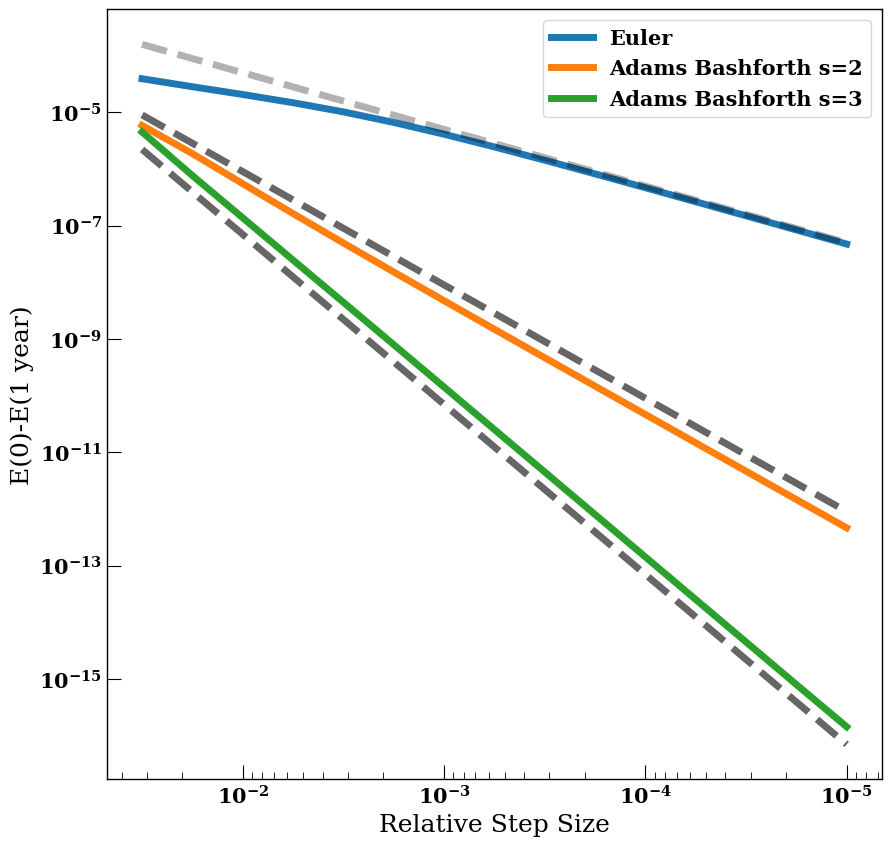

In [6]:
fig,ax = plt.subplots(figsize=(10,10))
plt.plot(dts,E_euler,label='Euler')
plt.plot(dts,E_AB2,label='Adams Bashforth s=2')
plt.plot(dts,E_AB3,label='Adams Bashforth s=3')
plt.plot(dts,dts*5e-3,c='k',ls='--',alpha=0.3)
plt.plot(dts,(dts**2)*9e-3,c='k',ls='--',alpha=0.6)
plt.plot(dts,(dts**3)*7e-2,c='k',ls='--',alpha=0.6)
plt.xscale('log')
plt.yscale('log')

plt.gca().invert_xaxis()
plt.xlabel("Relative Step Size")
plt.ylabel("E(0)-E(1 year)")
ax.legend(loc='best')
plt.savefig('multistep_errorstep.png')

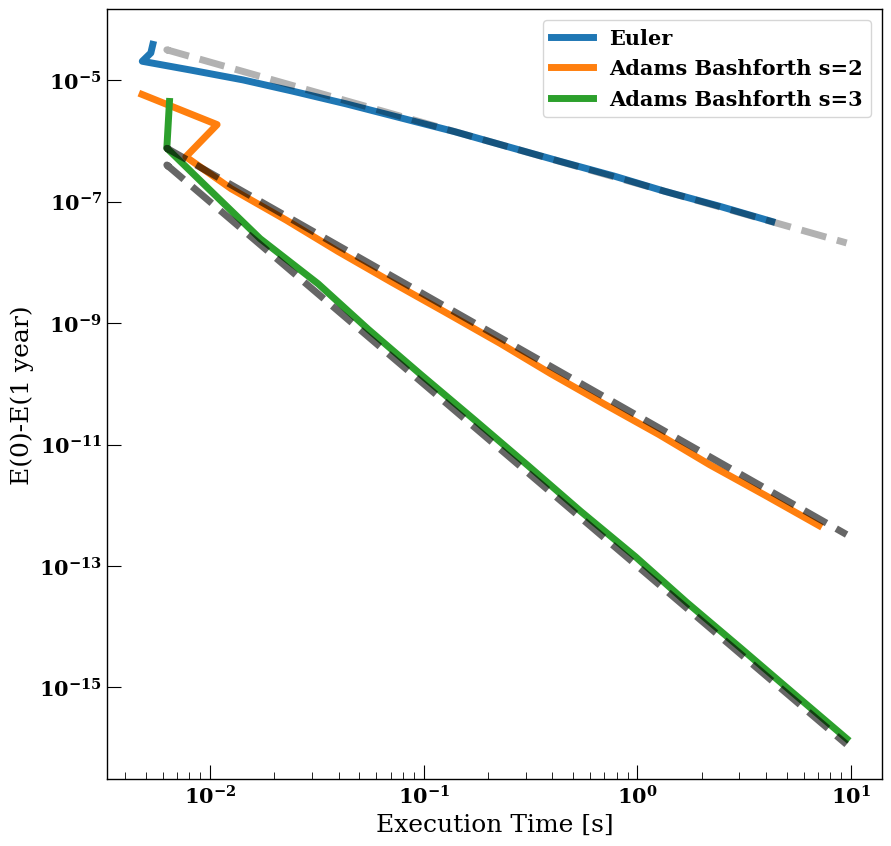

In [7]:
fig,ax = plt.subplots(figsize=(10,10))
plt.plot(T_euler,E_euler,label='Euler')
plt.plot(T_AB2,E_AB2,label='Adams Bashforth s=2')
plt.plot(T_AB3,E_AB3,label='Adams Bashforth s=3')
plt.plot(T_AB3,(np.array(T_AB3)**-1)*2e-7,c='k',ls='--',alpha=0.3)
plt.plot(T_AB3,(np.array(T_AB3)**-2)*3e-11,c='k',ls='--',alpha=0.6)
plt.plot(T_AB3,(np.array(T_AB3)**-3)*1e-13,c='k',ls='--',alpha=0.6)
plt.xscale('log')
plt.yscale('log')

#plt.gca().invert_xaxis()
plt.xlabel("Execution Time [s]")
plt.ylabel("E(0)-E(1 year)")
ax.legend(loc='best')
plt.savefig('multistep_errortime.png')
plt.show()